In [2]:
#C-P=S-PV(x)
# lets start with SH-300
# 一点200元,minimum change for contract is 0.2*300=60
#margin is 8% 期权100一点 期货300一点 call保证金15% put保证金 15% cash交割
# 实际操作的时候三手期权一手期货

import pandas as pd
import numpy as np
import time
import re
import os
import sys
import draw
# import backtest
from xtquant import xtdata, xtdatacenter
from datetime import datetime, timedelta
import read_xtdata
xtdata.download_history_contracts()

***** xtdata连接成功 2026-01-09 09:42:20*****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58610
数据路径: C:\data_xtdata\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [97]:

import matplotlib.pyplot as plt
stock_code:str='000300.SH'
period:str='1m'
contract_code="IF2512.IF"
strike:float=3800
option_code_call=f"IO2512-C-{strike}.IF"
option_code_put=f"IO2512-P-{strike}.IF"
def get_option_data(contract_code:str,period:str="1m",start_time:str="",end_time:str=""):
    xtdata.download_history_data(contract_code,period,start_time=start_time,end_time=end_time)
    xtdata.subscribe_quote(contract_code, period=period, start_time=start_time, end_time=end_time, callback=None)
    data=xtdata.get_market_data_ex([],[contract_code],period=period,start_time=start_time,end_time=end_time)
    time.sleep(1)
    d=data[contract_code]
    d["time"]=pd.to_datetime(d["time"],unit='ms')
    d["daily_average_volume"]=d["volume"].rolling(window=240).mean()
    return d


data_c=get_option_data(option_code_call,period)
c=data_c.copy()
data_p=get_option_data(option_code_put,period)
merged=pd.merge(data_c,data_p,on='time',suffixes=('_c','_p')) 
data_contracts=get_option_data(contract_code,period=period)
merged=pd.merge(merged,data_contracts,on='time',suffixes=('', '_contract'))
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2=ax1.twinx()
ax1.plot(c["time"],c["daily_average_volume"], 'g-', label='return')
ax2.plot(c["time"],c["volume"], 'b-', label='underlying')
# ax2.plot(merged["time"],merged["residual_z"], 'b-', label='z')
ax1.set_ylabel('average volumne', color='g')
ax2.set_ylabel('underlying volume', color='b')
plt.show()

In [85]:

#download data2 for a list and data for a single one
def zscore(series: pd.Series,adjust_option: bool=False,halffile:int=10) -> pd.Series:
    ewma_std = series.ewm(halflife=halffile, adjust=adjust_option).std()
    ewma_mean= series.ewm(halflife=halffile, adjust=adjust_option).mean()
    # 可选：将前30日EWMA波动率替换为滚动标准差
    res=(series - ewma_mean)/ ewma_std
    return res

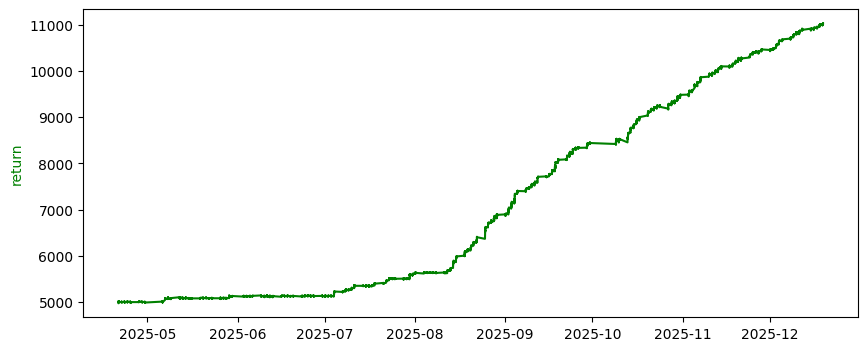

[(Timestamp('2025-04-21 01:30:00'), 'Enter long Contract', -23.999999999999716, 0.0, (0, 0, 0, 159.0, 275.8, 3659.2000000000003, 0, 0, 0, 0.0)), (Timestamp('2025-05-07 01:30:00'), 'Enter short Contract', 30.0000000000002, 53.999999999999915, (-1, 1, 1, 144.6, 241.8, 3732.8, 159.0, 275.8, 3659.2000000000003, 53.999999999999915)), (Timestamp('2025-05-07 01:31:00'), 'Enter long Contract', -12.799999999999528, 42.79999999999973, (1, -1, -1, 177.0, 225.20000000000002, 3739.0000000000005, 144.6, 241.8, 3732.8, 42.79999999999973)), (Timestamp('2025-05-29 02:22:00'), 'Enter short Contract', 10.000000000000284, 22.799999999999812, (-1, 1, 1, 148.0, 226.8, 3731.2000000000003, 177.0, 225.20000000000002, 3739.0000000000005, 22.799999999999812)), (Timestamp('2025-05-29 02:37:00'), 'Enter long Contract', -10.999999999999886, 21.00000000000017, (1, -1, -1, 150.0, 211.60000000000002, 3727.4, 148.0, 226.8, 3731.2000000000003, 21.00000000000017)), (Timestamp('2025-07-04 02:48:00'), 'Enter short Contract

: 

In [99]:
merged['C-P']=merged['close_c']-merged['close_p']
merged["residual"]=-merged['C-P']+merged['close']-strike
# residual>0 long contract short options
# merged["residual_z"]=zscore(merged["residual"],halffile=10)
# merged["residual_z"]=zscore(merged["residual"],halffile=60)
# merged["signal"]=merged["residual_z"]
# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(figsize=(10, 4))
# ax2 = ax1.twinx()
# # ax1.plot(merged["time"],merged["close"], 'g-', label='residual')
# ax2.plot(merged["time"],merged["residual"], 'b-', label='z')
# ax1.set_ylabel('residual', color='g')
# ax2.set_ylabel('z', color='b')
# plt.show()
# print(merged["residual"].describe())

def backtest_cp_parity(history:pd.DataFrame,threshold:float=10,  initial_capital:float=5000.0,fee:float=0.0003,useage:float=0.8,K:int=10):
    # used for pair trading backtest
    capital = initial_capital
    position_c=position_p=position_contract =0  # 持仓数量
    entry_price_x=entry_price_y =entry_price_contract=0  # 进场价格
    equity_curve = []  # 资金曲线记录
    history_record=[]
    history=history.copy()
    for idx, row in history.iterrows():
        score=row["residual"]
        price_c= row["close_c"]
        price_p= row["close_p"]
        price_contract=row["close"]
        # 进场条件
        # useage should be approximately 10 since the margin is 8%
        profit=position_c * (price_c - entry_price_x)+ position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract)
        
        overview=(position_c,position_p,position_contract,price_c,price_p,price_contract,entry_price_x,entry_price_y,entry_price_contract,profit)
        if score>threshold :
            if position_contract>=0:
                capital += profit
                position_c=position_p=position_contract=0
                position_contract= -useage * capital / (price_contract+price_c+price_p)
                position_contract=-1
                position_c= -position_contract
                position_p= position_contract
                entry_price_x=price_c
                entry_price_y=price_p
                entry_price_contract=price_contract
                commision=fee * (abs(position_c)*price_c + abs(position_p)*price_p + abs(position_contract)*price_contract)
                capital -= commision
                history_record.append((row["time"],"Enter short Contract",-strike+price_contract-price_c+price_p,profit,
                                       overview))
        elif score<-threshold:
            if position_contract<=0:
                capital +=profit
                position_c=position_p=position_contract=0
                position_contract= useage * capital /  (price_contract+price_c+price_p)
                position_contract=1
                position_c= -position_contract
                position_p= position_contract
                entry_price_x=price_c
                entry_price_y=price_p
                entry_price_contract=price_contract
                commision=fee * (abs(position_c)*price_c + abs(position_p)*price_p + abs(position_contract)*price_contract)
                capital -= commision
                history_record.append((row["time"],"Enter long Contract",-strike+price_contract-price_c+price_p,profit,
                                       overview))
        equity_curve.append(capital + position_c * (price_c - entry_price_x)+position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract))

    history['equity_curve'] = equity_curve
    return (history,history_record)

merged["residual_z"]=((merged["residual"]-merged["residual"].rolling(window=6000).mean())
                      /merged["residual"].rolling(window=6000).std())
data,record=backtest_cp_parity(merged[["residual_z","close_c","close_p","close","time","residual"]],threshold=10,fee=0.0003)
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(data["time"],data["equity_curve"], 'g-', label='return')
# ax2.plot(merged["time"],merged["residual_z"], 'b-', label='z')
ax1.set_ylabel('return', color='g')
plt.show()
print(record)
with open('output.txt', 'w', encoding='utf-8') as f:
    for item in record:
        f.write(str(item) + '\n')

In [77]:
print(xtdata.get_option_detail_data(option_code_call))

{'ExchangeID': 'CFFEX', 'InstrumentID': 'IO2512-C-3400', 'InstrumentName': 'IO2512C3400', 'ProductID': 'IO', 'ProductType': 6, 'OpenDate': '20250103', 'CreateDate': '20250102', 'ExpireDate': '20251219', 'PreClose': 1170.0, 'SettlementPrice': 1156.8, 'UpStopPrice': 1612.0, 'DownStopPrice': 701.6, 'LongMarginRatio': 0.0, 'ShortMarginRatio': 0.0, 'PriceTick': 0.2, 'VolumeMultiple': 100, 'MaxMarketOrderVolume': 0, 'MinMarketOrderVolume': 1, 'MaxLimitOrderVolume': 20, 'MinLimitOrderVolume': 1, 'OptUnit': 1.7976931348623157e+308, 'MarginUnit': 0.0, 'OptUndlCode': '000300', 'OptUndlUniCode': '000300', 'OptUndlMarket': 'SH', 'OptUndlCodeFull': '000300.SH', 'OptExercisePrice': 3400.0, 'NeeqExeType': 0, 'OptUndlRiskFreeRate': 0.018355999999999997, 'OptUndlHistoryRate': 0.1615106542369611, 'EndDelivDate': '20251219', 'OptEstimatedMargin': 204376.21344, 'optType': 'CALL', 'ProductCode': '000300.SH'}


In [25]:
def simple_total_return(series:pd.Series)->float:
    return series.iloc[-1]/series.iloc[0]-1

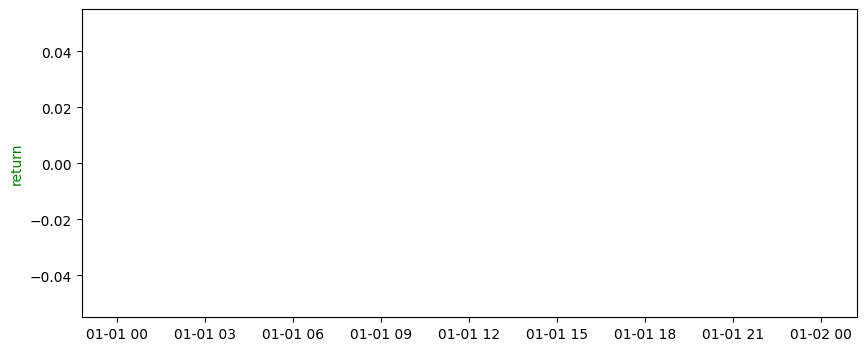

[]


In [96]:
def backtest_cp_parity(history:pd.DataFrame,threshold:float=10,  initial_capital:float=5000.0,fee:float=0.0003,useage:float=0.8,K:int=10):
    # used for pair trading backtest
    capital = initial_capital
    position_c=position_p=position_contract =0  # 持仓数量
    entry_price_x=entry_price_y =entry_price_contract=0  # 进场价格
    equity_curve = []  # 资金曲线记录
    history_record=[]
    history=history.copy()
    for idx, row in history.iterrows():
        score=row["residual"]
        price_c= row["close_c"]
        price_p= row["close_p"]
        price_contract=row["close"]
        # 进场条件
        # useage should be approximately 10 since the margin is 8%
        profit=position_c * (price_c - entry_price_x)+ position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract)
        
        overview=(position_c,position_p,position_contract,price_c,price_p,price_contract,entry_price_x,entry_price_y,entry_price_contract,profit)
        if score>threshold :
            if position_contract>=0:
                capital += profit
                position_c=position_p=position_contract=0
                position_contract= -useage * capital / (price_contract+price_c+price_p)
                position_contract=-1
                position_c= -position_contract
                position_p= position_contract
                entry_price_x=price_c
                entry_price_y=price_p
                entry_price_contract=price_contract
                commision=fee * (abs(position_c)*price_c + abs(position_p)*price_p + abs(position_contract)*price_contract)
                capital -= commision
                history_record.append((row["time"],"Enter short Contract",-strike+price_contract-price_c+price_p,profit,
                                       overview))
        elif score<-threshold:
            if position_contract<=0:
                capital +=profit
                position_c=position_p=position_contract=0
                position_contract= useage * capital /  (price_contract+price_c+price_p)
                position_contract=1
                position_c= -position_contract
                position_p= position_contract
                entry_price_x=price_c
                entry_price_y=price_p
                entry_price_contract=price_contract
                commision=fee * (abs(position_c)*price_c + abs(position_p)*price_p + abs(position_contract)*price_contract)
                capital -= commision
                history_record.append((row["time"],"Enter long Contract",-strike+price_contract-price_c+price_p,profit,
                                       overview))
        equity_curve.append(capital + position_c * (price_c - entry_price_x)+position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract))

    history['equity_curve'] = equity_curve
    return (history,history_record)
merged["residual_z"]=((merged["residual"]-merged["residual"].rolling(window=6000).mean())
                      /merged["residual"].rolling(window=6000).std())
data,record=backtest_cp_parity(merged[["residual_z","close_c","close_p","close","time","residual"]],threshold=10,fee=0.0003)
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(data["time"],data["equity_curve"], 'g-', label='return')
# ax2.plot(merged["time"],merged["residual_z"], 'b-', label='z')
ax1.set_ylabel('return', color='g')

plt.show()
print(record)
with open('output.txt', 'w', encoding='utf-8') as f:
    for item in record:
        f.write(str(item) + '\n')

In [15]:
with open('output.txt', 'w', encoding='utf-8') as f:
    for item in record:
        f.write(str(item) + '\n')

In [36]:
def backtest_cp_parity(history:pd.DataFrame,threshold:float=10,  initial_capital:float=100000.0,fee:float=0.0003,useage:float=0.8,K:int=10):
    # used for pair trading backtest
    capital = initial_capital
    position_c=position_p=position_contract =0  # 持仓数量
    entry_price_x=entry_price_y =entry_price_contract=0  # 进场价格
    equity_curve = []  # 资金曲线记录
    history_record=[]
    history=history.copy()
    for idx, row in history.iterrows():
        score=row["residual"]
        price_c= row["close_c"]
        price_p= row["close_p"]
        price_contract=row["close"]
        # 进场条件
        # useage should be approximately 10 since the margin is 8%
        if score<-threshold :
            if position_contract>=0:
                capital += position_c * (price_c - entry_price_x)+ position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract)
                position_c=position_p=position_contract=0
                position_contract= -useage * capital / price_contract
                position_c= position_contract
                position_p= -position_contract
                entry_price_x=price_c
                entry_price_y=price_p
                entry_price_contract=price_contract
                capital -= fee * (abs(position_c)*price_c + abs(position_p)*price_p + abs(position_contract)*price_contract)
                history_record.append((row["time"],"Enter short Contract",price_contract-price_c+price_p-strike))
        elif score>threshold:
            if position_contract<=0:
                capital += position_c * (price_c - entry_price_x)+ position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract)
                position_c=position_p=position_contract=0
                position_contract= useage * capital / price_contract
                position_c= -position_contract
                position_p= position_contract
                entry_price_x=price_c
                entry_price_y=price_p
                entry_price_contract=price_contract
                capital -= fee * (abs(position_c)*price_c + abs(position_p)*price_p + abs(position_contract)*price_contract)
                history_record.append((row["time"],"Enter long Contract",price_contract-price_c+price_p-strike))
        # 记录资金曲线
        equity_curve.append(capital + position_c * (price_c - entry_price_x)+position_p * (price_p - entry_price_y)+ position_contract * (price_contract - entry_price_contract)
                            if position_c != 0 else capital)

    history['equity_curve'] = equity_curve
    return (history,history_record)